# import data

In [1]:
from __future__ import annotations

from typing import Literal
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_STATE = 28

In [3]:
# FutureWarningを無視
warnings.simplefilter(action='ignore', category=FutureWarning)

# RuntimeWarningを無視
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Functions

In [4]:
def make_mock_indirect_kpi_data(
    n: int = 36, # 3年分
    seed: int = RANDOM_STATE,
) -> tuple[pd.DataFrame, pd.Series]:
    """間接部門を想定したKPIのモックデータを生成します。

    観測KPIに多重共線性が生じるよう、3つの潜在要因（業務の「束」）からデータを生成します。

    - digital: デジタル施策 系
    - event_sales: イベント／ウェビナー／営業訪問　系
    - price_cond: 価格・競合圧力束（成約率に負に効く想定）

    Args:
        n: 観測数（例：月次データの月数）。正の整数
        seed: 乱数シード。再現性確保のために使用します。

    Returns:
        以下のタプルを返します。
            - X: 観測されたKPIからなる特徴量行列（形状: [n, p]）。
            - y: 成約率を表す目的変数（0〜1の範囲）で、名前は
              "deal_conversion_rate" です。

    Raises:
        ValueError: n が正の整数でない場合に発生します。
    """
    if n <= 0:
        raise ValueError("n must be a positive integer.")

    rng = np.random.default_rng(seed)

    def _clip01(x: np.ndarray) -> np.ndarray:
        return np.clip(x, 0.0, 1.0)

    # 潜在要因（業務の“束”）
    digital = rng.normal(0, 1, n)
    event_sales = rng.normal(0, 1, n)
    price_cond = rng.normal(0, 1, n)

    # 任意：緩い季節性（全体に少し相関を作る／説明しやすい）
    t = np.arange(n)
    season = np.sin(2 * np.pi * t / 12.0)

    X = pd.DataFrame(
        {
            # digital束 16cases
            "mail_sends": np.clip(50 + 10 * digital + 3 * season + rng.normal(0, 3, n), 0, None),
            "mail_delivered": np.clip(48 + 9.5 * digital + 3 * season + rng.normal(0, 3, n), 0, None),
            "open_rate": _clip01(0.25 + 0.05 * digital + 0.01 * season + rng.normal(0, 0.02, n)),
            "click_rate": _clip01(0.04 + 0.02 * digital + 0.005 * season + rng.normal(0, 0.01, n)),
            "web_visits": np.clip(200 + 40 * digital + 10 * season + rng.normal(0, 15, n), 0, None),
            "unique_visitors": np.clip(140 + 30 * digital + 8 * season + rng.normal(0, 12, n), 0, None),
            "content_views": np.clip(500 + 90 * digital + 20 * season + rng.normal(0, 30, n), 0, None),
            "whitepaper_dl": np.clip(20 + 6 * digital + 2 * season + rng.normal(0, 2, n), 0, None),
            "avg_session_time_sec": np.clip(120 + 25 * digital + 5 * season + rng.normal(0, 10, n), 10, None),
            "bounce_rate": _clip01(0.55 - 0.08 * digital - 0.01 * season + rng.normal(0, 0.03, n)),
            "seo_rank_score": np.clip(60 + 8 * digital + 2 * season + rng.normal(0, 3, n), 0, None),
            "paid_search_impressions": np.clip(4000 + 700 * digital + 150 * season + rng.normal(0, 250, n), 0, None),
            "paid_search_clicks": np.clip(120 + 30 * digital + 10 * season + rng.normal(0, 10, n), 0, None),
            "cpc_yen": np.clip(180 - 20 * digital + rng.normal(0, 8, n), 30, None),  # 品質改善でCPC低下の想定
            "retargeting_impressions": np.clip(2500 + 500 * digital + 120 * season + rng.normal(0, 200, n), 0, None),
            "mql_count": np.clip(35 + 7.5 * digital + 2 * season + rng.normal(0, 3, n), 0, None),

            # event_sales束 16cases
            "event_registrations": np.clip(45 + 10 * event_sales + 4 * season + rng.normal(0, 4, n), 0, None),
            "event_attend": np.clip(30 + 8 * event_sales + 3 * season + rng.normal(0, 3, n), 0, None),
            "webinar_registrations": np.clip(40 + 9 * event_sales + 4 * season + rng.normal(0, 4, n), 0, None),
            "webinar_join": np.clip(25 + 7 * event_sales + 3 * season + rng.normal(0, 3, n), 0, None),
            "webinar_questions": np.clip(12 + 3.5 * event_sales + rng.normal(0, 2, n), 0, None),
            "sales_visits": np.clip(40 + 9 * event_sales + 2 * season + rng.normal(0, 4, n), 0, None),
            "sales_calls": np.clip(80 + 15 * event_sales + 3 * season + rng.normal(0, 7, n), 0, None),
            "demo_requests": np.clip(18 + 5.5 * event_sales + 1 * season + rng.normal(0, 2.5, n), 0, None),
            "tech_inquiry": np.clip(10 + 4 * event_sales + rng.normal(0, 2, n), 0, None),
            "sample_shipments": np.clip(8 + 2.8 * event_sales + rng.normal(0, 1.5, n), 0, None),
            "proposal_sent": np.clip(16 + 4.5 * event_sales + rng.normal(0, 2, n), 0, None),
            "proposal_value_million_yen": np.clip(22 + 6.0 * event_sales + rng.normal(0, 4, n), 0, None),
            "followup_emails": np.clip(60 + 12 * event_sales + rng.normal(0, 6, n), 0, None),
            "meeting_minutes": np.clip(900 + 180 * event_sales + rng.normal(0, 120, n), 0, None),
            "partner_referrals": np.clip(6 + 2.0 * event_sales + rng.normal(0, 1.2, n), 0, None),
            "mql_to_sql_rate": _clip01(0.25 + 0.06 * event_sales + rng.normal(0, 0.03, n)),

            # price_cond束（負に効く想定）13cases
            "price_up_flag": (price_cond > 0.3).astype(int),
            "discount_rate": _clip01(0.08 + 0.03 * price_cond + rng.normal(0, 0.01, n)),
            "competitor_pressure": np.clip(50 + 12 * price_cond + 2 * season + rng.normal(0, 4, n), 0, None),
            "competitor_price_index": np.clip(100 + 6 * price_cond + rng.normal(0, 2.5, n), 70, None),
            "bid_lost_rate": _clip01(0.35 + 0.07 * price_cond + rng.normal(0, 0.03, n)),
            "customer_budget_tightness": np.clip(50 + 10 * price_cond + rng.normal(0, 5, n), 0, None),
            "fx_volatility_index": np.clip(15 + 3.5 * price_cond + rng.normal(0, 1.8, n), 0, None),
            "raw_material_cost_index": np.clip(100 + 7 * price_cond + rng.normal(0, 3, n), 70, None),
            "margin_pressure_score": np.clip(40 + 11 * price_cond + rng.normal(0, 4, n), 0, None),
            "procurement_lead_time_days": np.clip(30 + 6 * price_cond + rng.normal(0, 3, n), 5, None),
            "delivery_delay_flag": (price_cond + rng.normal(0, 0.6, n) > 0.8).astype(int),
            "stockout_risk_score": np.clip(35 + 9 * price_cond + rng.normal(0, 4, n), 0, None),
            "price_sensitivity_score": np.clip(50 + 10 * price_cond + rng.normal(0, 5, n), 0, None),
        }
    )
    # 0,1に出力するため、ロジスティック回帰で目的変数を作成
    y_latent = 0.9 * digital + 1.1 * event_sales - 1.2 * price_cond + rng.normal(0, 0.7, n)
    y = 1 / (1 + np.exp(-y_latent))

    return X, pd.Series(y, name="deal_conversion_rate")

In [5]:
def rmse(
    y_true: pd.Series | np.ndarray,
    y_pred: pd.Series | np.ndarray,
) -> float:
    """RMSE（平方平均二乗誤差の平方根）を計算します。

    Args:
        y_true: 実測値（正解データ）。
        y_pred: モデルによる予測値。y_true と同じ順序・長さである必要があります。

    Returns:
        RMSE を表す浮動小数点数を返します。
    """
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [6]:
def aic_bic_from_rss(n: int, rss: float, k: int) -> tuple[float, float]:
    """RSS（残差平方和）から AIC と BIC を計算します。

    誤差が正規分布に従うと仮定した場合の近似式を用います。

        AIC = n * ln(RSS / n) + 2k  
        BIC = n * ln(RSS / n) + k * ln(n)

    Args:
        n: 観測数（サンプルサイズ）。
        rss: 残差平方和（Residual Sum of Squares）。
        k: モデルのパラメータ数（またはその代理となる複雑度指標）。

    Returns:
        (AIC, BIC) のタプルを返します。

    Raises:
        ValueError: n <= 0、k <= 0、または rss <= 0 の場合に発生します。
    """
    if n <= 0:
        raise ValueError("n must be positive.")
    if k <= 0:
        raise ValueError("k must be positive.")
    if rss <= 0:
        raise ValueError("rss must be positive to compute log(rss / n).")

    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)
    return float(aic), float(bic)

In [7]:
def eval_components(
    kind: Literal["PLS", "PCR"],
    X: pd.DataFrame,
    y: pd.Series,
    cv: KFold,
    max_k: int = 10,
) -> tuple[pd.DataFrame, dict[int, np.ndarray], int]:
    """PLS または PCR において、成分数を変化させた場合の性能を評価します。

    成分数 k = 1 〜 max_k について、以下を計算します。

    - cross_val_predict による交差検証予測値
    - CV RMSE
    - 全データで学習した際の RSS と、それに基づく AIC / BIC

    Args:
        kind: 評価対象のモデル種別。"PLS" または "PCR" を指定します。
        X: 特徴量行列（説明変数）。
        y: 目的変数。
        cv: 交差検証の分割方法（KFold など）。
        max_k: 試行する最大成分数。1以上である必要があります。

    Returns:
        以下のタプルを返します。
            - df: 成分数ごとの評価結果をまとめた DataFrame
              （列: ["k", "cv_rmse", "AIC", "BIC"]）
            - preds: 成分数 k をキー、CV予測値（numpy配列）を値とする辞書
            - best_k: CV RMSE が最小となる成分数

    Raises:
        ValueError: kind が不正、または max_k < 1 の場合に発生します。
    """
    # Error対応
    if max_k < 1:
        raise ValueError("max_k must be >= 1.")
    if kind not in ("PLS", "PCR"):
        raise ValueError('kind must be either "PLS" or "PCR".')

    # 交差検証
    rows: list[tuple[int, float, float, float]] = []
    preds: dict[int, np.ndarray] = {}

    for k in range(1, max_k + 1):
        if kind == "PLS":
            model: Pipeline = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    ("m", PLSRegression(n_components=k)),
                ]
            )
        else:  # PCR
            model = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    ("pca", PCA(n_components=k)),
                    ("m", LinearRegression()),
                ]
            )
        # 検証
        y_pred = cross_val_predict(model, X, y, cv=cv)
        preds[k] = y_pred
        cv_rmse = rmse(y, y_pred)

        model.fit(X, y)
        y_fit = model.predict(X).ravel()

        # 誤差計算
        rss = float(np.sum((y.to_numpy() - y_fit) ** 2))
        # 成分数 k に切片相当 (+1) を加え、複雑度の代理指標とする
        aic, bic = aic_bic_from_rss(len(y), rss, k + 1)

        rows.append((k, cv_rmse, aic, bic))

    # 出力結果をまとめる
    df = pd.DataFrame(rows, columns=["k", "cv_rmse", "AIC", "BIC"])
    best_k = int(df.sort_values("cv_rmse").iloc[0]["k"])
    return df, preds, best_k

In [8]:
def calculate_vif(X: pd.DataFrame) -> pd.DataFrame:
    """多重共線性の評価としてVIF（Variance Inflation Factor）を計算します。
    
    Args:
        X: 特徴量行列（説明変数）。pd.DataFrame形式。
    
    Returns:
        VIF値を含むDataFrame（列: ['feature', 'VIF']）。
        VIFが大きいほど多重共線性が高いことを示します。
        一般的に、VIF > 10 の場合、多重共線性が高いと判断されます。
    """
    # 定数項を追加
    X_with_const = add_constant(X, prepend=False)
    
    # 各特徴量についてVIFを計算
    vif_values = []
    feature_names = []
    
    # 定数項以外の列についてVIFを計算
    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X_with_const.values, i)
        vif_values.append(vif)
        feature_names.append(X.columns[i])
    
    # DataFrameとして整理
    vif_df = pd.DataFrame({
        'feature': feature_names,
        'VIF': vif_values
    }).sort_values('VIF', ascending=False)
    
    return vif_df

# Run code

In [9]:
# データテーブル生成
X, y = make_mock_indirect_kpi_data()

display(X.head())
print(X.shape)

,mail_sends,mail_delivered,open_rate,click_rate,web_visits,unique_visitors,content_views,whitepaper_dl,avg_session_time_sec,bounce_rate,...,competitor_price_index,bid_lost_rate,customer_budget_tightness,fx_volatility_index,raw_material_cost_index,margin_pressure_score,procurement_lead_time_days,delivery_delay_flag,stockout_risk_score,price_sensitivity_score
0,43.956449,34.775729,0.170806,0.015370,180.843821,103.930363,435.643083,14.460979,83.242512,0.638808,...,106.448190,0.367617,52.502797,18.819862,101.015670,45.117125,32.957105,0,37.258419,53.482783
1,44.729866,45.112247,0.248821,0.060998,212.263762,132.552377,524.728582,20.854550,127.856441,0.562602,...,101.275770,0.392900,45.241456,13.616307,100.398015,38.095001,32.334136,0,28.918689,56.293454
2,46.952336,44.223104,0.239303,0.039747,205.525752,140.006387,518.336901,22.692273,137.656105,0.501333,...,103.568370,0.356725,52.543221,18.179010,105.755151,49.694379,36.412460,0,45.553038,65.204484
3,41.171322,48.064259,0.257822,0.037931,203.331108,131.788264,487.164445,17.936140,103.142060,0.541523,...,102.962465,0.349321,53.265947,17.323133,108.157833,50.977316,28.941755,0,41.019070,56.271786
4,56.187109,51.736509,0.279005,0.055767,231.036336,153.469727,570.660354,22.967792,154.672213,0.568906,...,94.538551,0.317837,37.767480,13.693573,91.878034,30.936892,24.815450,0,29.036871,41.854833


(36, 45)


In [10]:
display(y.head())
print(y.shape)

0    0.200869
1    0.338442
2    0.246499
3    0.060953
4    0.836354
Name: deal_conversion_rate, dtype: float64

(36,)


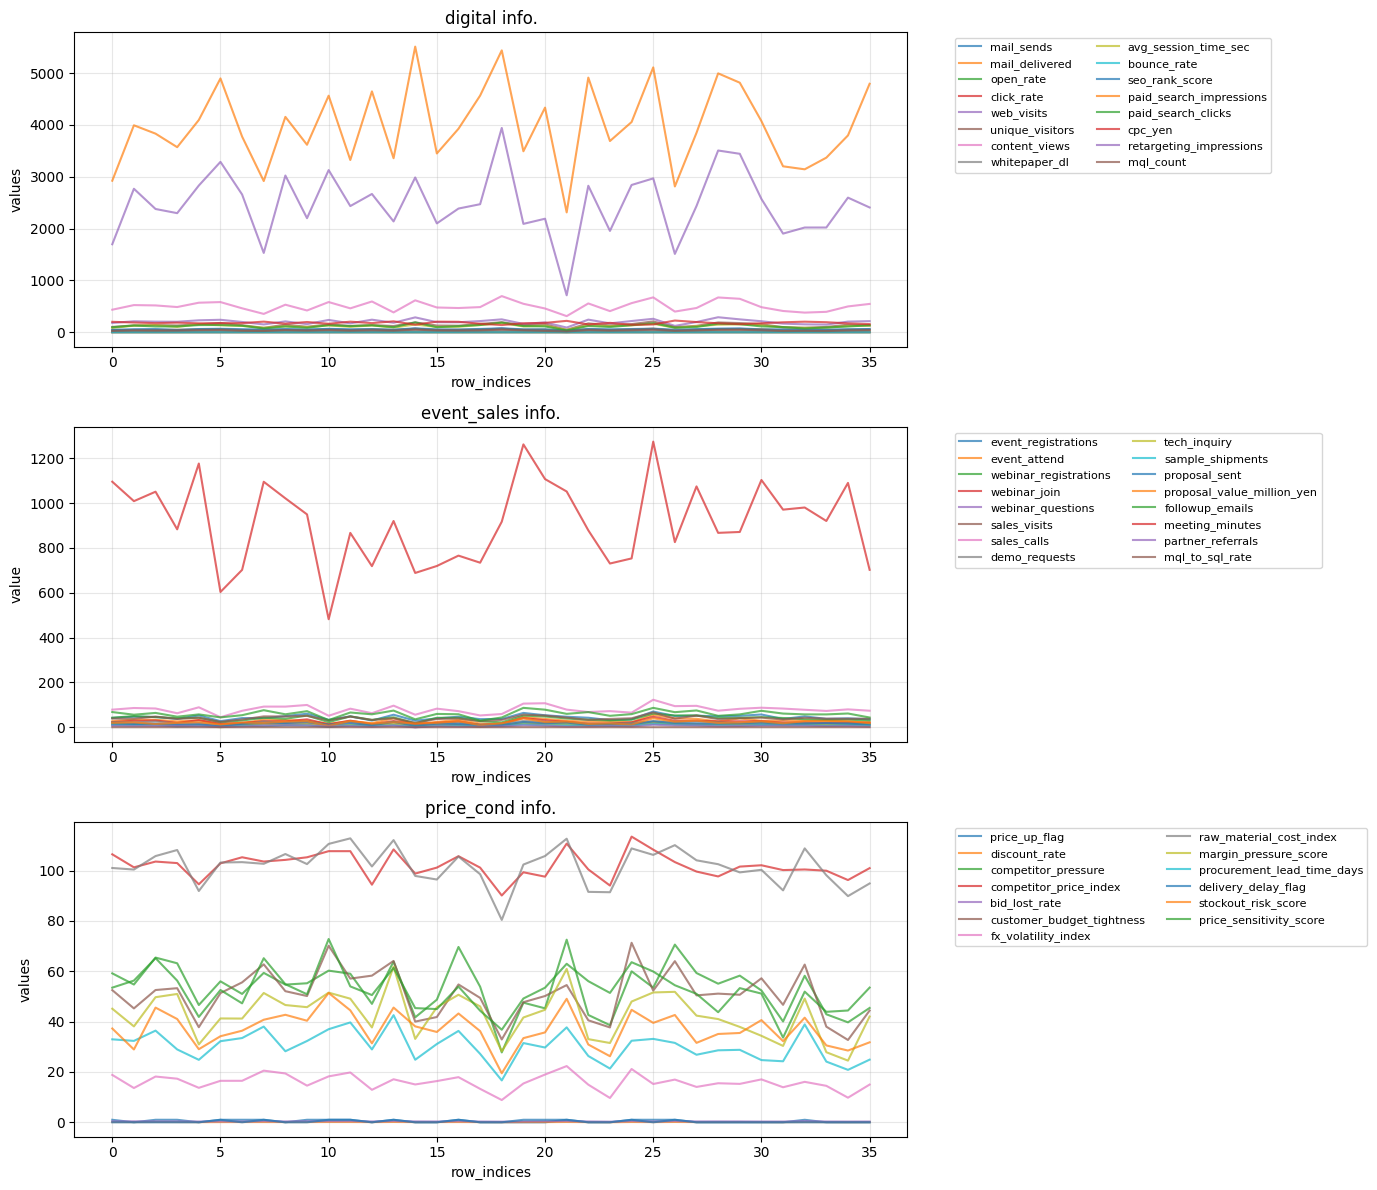

In [11]:
# 3つの潜在因子グループごとの時系列可視化（lineplot）
# 各潜在因子グループの特徴量を定義
digital_features = [
    'mail_sends', 'mail_delivered', 'open_rate', 'click_rate', 'web_visits',
    'unique_visitors', 'content_views', 'whitepaper_dl', 'avg_session_time_sec',
    'bounce_rate', 'seo_rank_score', 'paid_search_impressions', 'paid_search_clicks',
    'cpc_yen', 'retargeting_impressions', 'mql_count'
]

event_sales_features = [
    'event_registrations', 'event_attend', 'webinar_registrations', 'webinar_join',
    'webinar_questions', 'sales_visits', 'sales_calls', 'demo_requests', 'tech_inquiry',
    'sample_shipments', 'proposal_sent', 'proposal_value_million_yen', 'followup_emails',
    'meeting_minutes', 'partner_referrals', 'mql_to_sql_rate'
]

price_cond_features = [
    'price_up_flag', 'discount_rate', 'competitor_pressure', 'competitor_price_index',
    'bid_lost_rate', 'customer_budget_tightness', 'fx_volatility_index',
    'raw_material_cost_index', 'margin_pressure_score', 'procurement_lead_time_days',
    'delivery_delay_flag', 'stockout_risk_score', 'price_sensitivity_score'
]

# 行番号（時系列インデックス）を作成
row_indices = np.arange(len(X))

# 3つの潜在因子グループごとにlineplotを作成
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. digital束（デジタル施策系）
ax1 = axes[0]
for col in digital_features:
    if col in X.columns:
        ax1.plot(row_indices, X[col], label=col, alpha=0.7, linewidth=1.5)
ax1.set_xlabel('row_indices')
ax1.set_ylabel('values')
ax1.set_title('digital info.')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)

# 2. event_sales束（イベント／ウェビナー／営業訪問系）
ax2 = axes[1]
for col in event_sales_features:
    if col in X.columns:
        ax2.plot(row_indices, X[col], label=col, alpha=0.7, linewidth=1.5)
ax2.set_xlabel('row_indices')
ax2.set_ylabel('value')
ax2.set_title('event_sales info.')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)

# 3. price_cond束（価格・競合圧力束）
ax3 = axes[2]
for col in price_cond_features:
    if col in X.columns:
        ax3.plot(row_indices, X[col], label=col, alpha=0.7, linewidth=1.5)
ax3.set_xlabel('row_indices')
ax3.set_ylabel('values')
ax3.set_title('price_cond info.')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# VIFを計算して表示
vif_result = calculate_vif(X)
display(vif_result.head(10))

,feature,VIF
0,mail_sends,inf
23,demo_requests,inf
25,sample_shipments,inf
26,proposal_sent,inf
27,proposal_value_million_yen,inf
28,followup_emails,inf
29,meeting_minutes,inf
30,partner_referrals,inf
31,mql_to_sql_rate,inf
32,price_up_flag,inf


### Cross validation

In [13]:
# 行方向が小さいのでK-Foldで交差検証を実施
# 月次のデータなので、4半期ごとに分割して交差検証を実施
n_split = len(X) // 4
cv = KFold(n_splits=n_split, shuffle=False)

# --- PLS / PCR: 成分数探索
pls_df, pls_pred, best_pls = eval_components("PLS", X, y, cv=cv)
pcr_df, pcr_pred, best_pcr = eval_components("PCR", X, y, cv=cv)

# --- Ridge: 正則化強度探索
ridge_rows: list[tuple[float, float]] = []
for alpha in [0.1, 1, 10, 100, 1000]:
    model = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("m", Ridge(alpha=alpha))
        ]
    )
    y_pred = cross_val_predict(model, X, y, cv=cv)
    ridge_rows.append((float(alpha), rmse(y, y_pred)))

ridge_df = pd.DataFrame(ridge_rows, columns=["alpha", "cv_rmse"])
best_alpha = float(ridge_df.sort_values("cv_rmse").iloc[0]["alpha"])

# best_alphaに対して予測
ridge_best_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("m", Ridge(alpha=best_alpha))
    ]
)
ridge_pred = cross_val_predict(ridge_best_model, X, y, cv=cv)

# --- Lasso: 正則化強度探索
lasso_rows: list[tuple[float, float]] = []
max_iter = 50000 # Lassoは収束しないことがあるので max_iter を増やす
for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("m", Lasso(alpha=alpha, max_iter=max_iter))
        ]
    )
    y_pred = cross_val_predict(model, X, y, cv=cv)
    lasso_rows.append((float(alpha), rmse(y, y_pred)))

lasso_df = pd.DataFrame(lasso_rows, columns=["alpha", "cv_rmse"])
best_lasso_alpha = float(lasso_df.sort_values("cv_rmse").iloc[0]["alpha"])

# best_lasso_alphaに対して予測
lasso_best_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("m", Lasso(alpha=best_lasso_alpha, max_iter=max_iter))
    ]
)
lasso_pred = cross_val_predict(lasso_best_model, X, y, cv=cv)

print("PLS\n", pls_df, "\nbest_k:", best_pls)
print("\nPCR\n", pcr_df, "\nbest_k:", best_pcr)
print("\nRidge\n", ridge_df, "\nbest_alpha:", best_alpha)
print("\nLasso\n", lasso_df, "\nbest_alpha:", best_lasso_alpha)

PLS
     k   cv_rmse         AIC         BIC
0   1  0.174831 -130.010350 -126.843312
1   2  0.159331 -139.381261 -134.630704
2   3  0.180656 -142.390363 -136.056287
3   4  0.192628 -165.747999 -157.830405
4   5  0.198972 -178.221061 -168.719948
5   6  0.220636 -188.561116 -177.476483
6   7  0.256246 -199.750500 -187.082348
7   8  0.273036 -208.297985 -194.046314
8   9  0.286748 -216.614599 -200.779410
9  10  0.293356 -224.552455 -207.133746 
best_k: 2

PCR
     k   cv_rmse         AIC         BIC
0   1  0.318394  -82.524362  -79.357324
1   2  0.164999 -127.338664 -122.588107
2   3  0.166886 -135.261308 -128.927232
3   4  0.164778 -135.565591 -127.647996
4   5  0.166599 -133.607323 -124.106210
5   6  0.168146 -131.622213 -120.537580
6   7  0.176622 -129.689090 -117.020938
7   8  0.184442 -128.208003 -113.956333
8   9  0.187014 -127.491100 -111.655911
9  10  0.197347 -126.081974 -108.663266 
best_k: 4

Ridge
     alpha   cv_rmse
0     0.1  0.296273
1     1.0  0.228986
2    10.0  0.175751

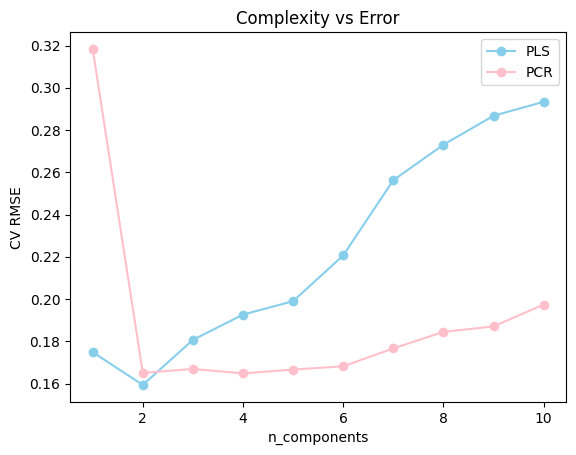

In [14]:
# PLS, PCR回帰の成分数とRMSEの比較
plt.figure()
plt.plot(pls_df["k"], pls_df["cv_rmse"], marker="o", label="PLS", color="skyblue")
plt.plot(pcr_df["k"], pcr_df["cv_rmse"], marker="o", label="PCR", color="pink")
plt.xlabel("n_components")
plt.ylabel("CV RMSE")
plt.title("Complexity vs Error")
plt.legend()
plt.show()

### calculate as best-param

In [15]:
pls_best = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("m", PLSRegression(n_components=best_pls))
    ]).fit(X, y)
pcr_best = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=best_pcr)),
        ("m", LinearRegression())
    ]).fit(X, y)
ridge_best = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("m", Ridge(alpha=best_alpha))
    ]).fit(X, y)
lasso_best = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("m", Lasso(alpha=best_lasso_alpha, max_iter=max_iter))
    ]).fit(X, y)

# 元の説明変数に対する係数を抽出
pls_coef = pd.Series(
    pls_best.named_steps["m"].coef_.ravel(),
    index=X.columns).sort_values()

pcr_coef = pd.Series(
    pcr_best.named_steps["m"].coef_.ravel(),
    index=[f"PC{i}" for i in range(best_pcr)]).sort_values()

ridge_coef = pd.Series(
    ridge_best.named_steps["m"].coef_.ravel(),
    index=X.columns).sort_values()

lasso_coef = pd.Series(
    lasso_best.named_steps["m"].coef_.ravel(),
    index=X.columns).sort_values()


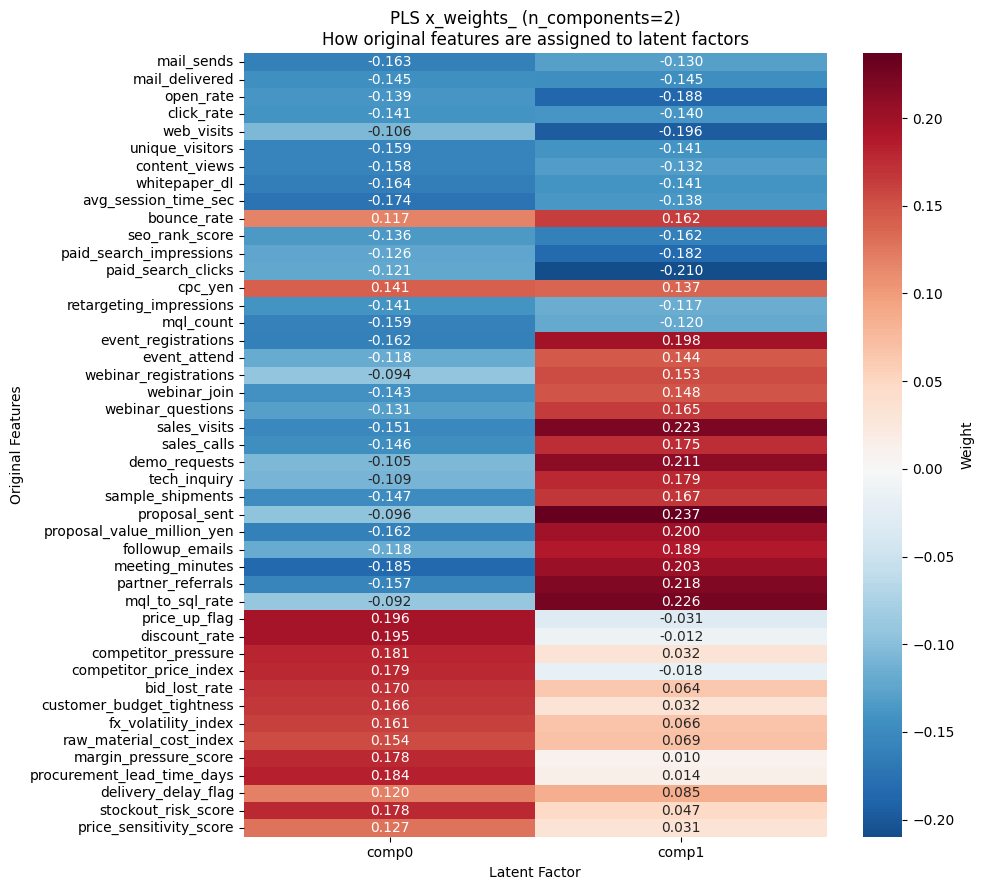

In [16]:
# 説明変数に対するPLSの重み
# |重み|が大きい変数ほど、その成分を強く規定
pls = pls_best.named_steps["m"]
weights = pd.DataFrame(
    pls.x_weights_,
    index=X.columns,
    columns=[f"comp{i}" for i in range(best_pls)]
)
# PLSのx_weights_をヒートマップで可視化
# 元の説明変数が潜在因子にどう割り当てられているかを確認
plt.figure(figsize=(10, max(8, int(len(weights.index) * 0.2))))  # 行数に応じて高さ調整
ax = sns.heatmap(
    weights,
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",
    center=0, 
    cbar_kws={"label": "Weight"},
    yticklabels=weights.index  # yticklabelsを明示
)
plt.title(f"PLS x_weights_ (n_components={best_pls})\nHow original features are assigned to latent factors")
plt.xlabel("Latent Factor")
plt.ylabel("Original Features")
plt.subplots_adjust(left=0.30, right=0.98, top=0.92, bottom=0.08) # マージン調整
plt.tight_layout()
plt.show()

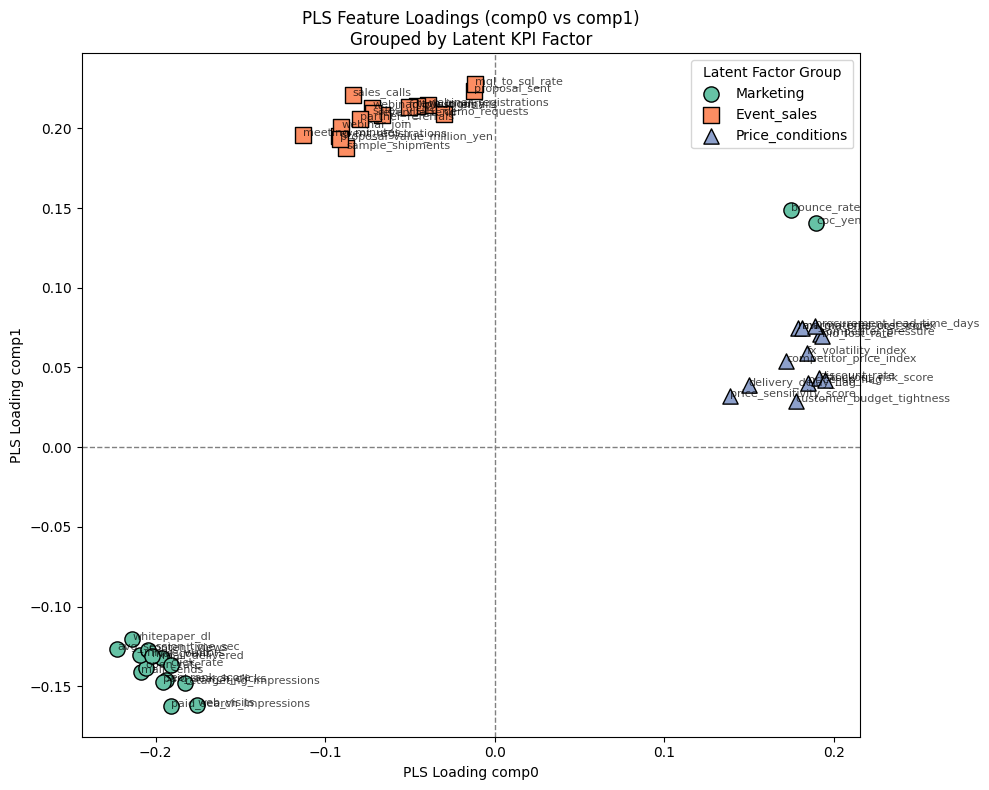

In [17]:
# 説明変数に対するPLSのloading（成分がX空間のどの方向を表しているか）
pls = pls_best.named_steps["m"]
loadings = pd.DataFrame(
    pls.x_loadings_,
    index=X.columns,
    columns=[f"comp{i}" for i in range(best_pls)]
)

# make_mock_indirect_kpi_data関数内で説明変数がどの潜在要因グループか
kpi_groups = {
    'Marketing': digital_features,
    'Event_sales': event_sales_features,
    'Price_conditions': price_cond_features
}

# 変数名→グループ名 の辞書を作成
feature2group = {}
for group, features in kpi_groups.items():
    for feat in features:
        feature2group[feat] = group

feature_groups = X.columns.map(feature2group)


plt.figure(figsize=(10, 8))

groups = feature_groups.unique()
markers = ['o', 's', '^']  # グループごとのマーカー
colors = sns.color_palette("Set2", n_colors=len(groups))

for i, group in enumerate(groups):
    idx = (feature_groups == group)
    plt.scatter(
        loadings.loc[idx, 'comp0'], 
        loadings.loc[idx, 'comp1'], 
        label=group, 
        marker=markers[i % len(markers)],
        s=120,
        c=[colors[i]],
        edgecolors='k' # マーカー視認性
    )
    # 変数名付与（小さく）
    for feat in loadings.index[idx]:
        plt.text(loadings.loc[feat, 'comp0'], loadings.loc[feat, 'comp1'], feat, fontsize=8, alpha=0.7)

plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)

plt.xlabel('PLS Loading comp0')
plt.ylabel('PLS Loading comp1')
plt.title('PLS Feature Loadings (comp0 vs comp1)\nGrouped by Latent KPI Factor')
plt.legend(title="Latent Factor Group", loc="best")
plt.tight_layout()
plt.show()

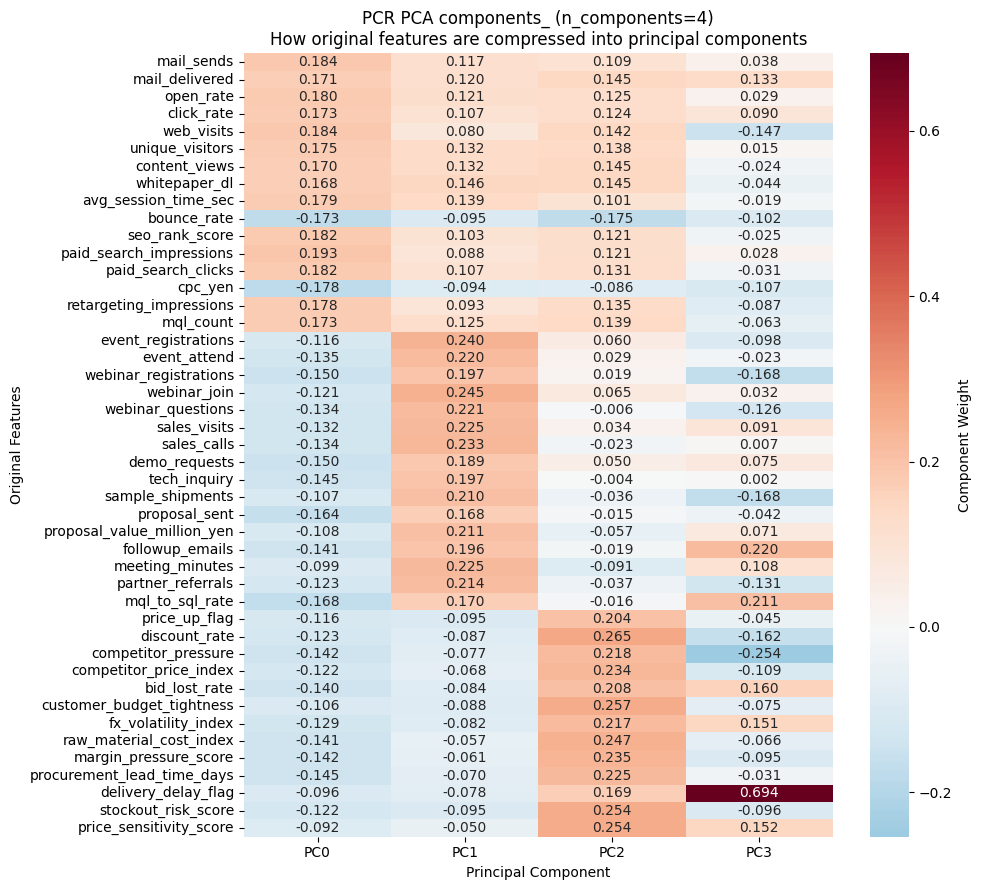

In [18]:
# PCRのPCAの主成分への重み（components_）
# 元の説明変数が主成分にどう圧縮されているかを確認
pca = pcr_best.named_steps["pca"]
pcr_components = pd.DataFrame(
    pca.components_.T,  # 転置して、行=元の説明変数、列=主成分
    index=X.columns,
    columns=[f"PC{i}" for i in range(best_pcr)]
)

# PCRのPCAのcomponents_をヒートマップで可視化
plt.figure(figsize=(10, max(8, int(len(weights.index) * 0.2))))  # 行数に応じて高さ調整
sns.heatmap(pcr_components, annot=True, fmt=".3f", cmap="RdBu_r", center=0,
            cbar_kws={"label": "Component Weight"})
plt.title(f"PCR PCA components_ (n_components={best_pcr})\nHow original features are compressed into principal components")
plt.xlabel("Principal Component")
plt.ylabel("Original Features")
plt.tight_layout()
plt.show()

### Visualization

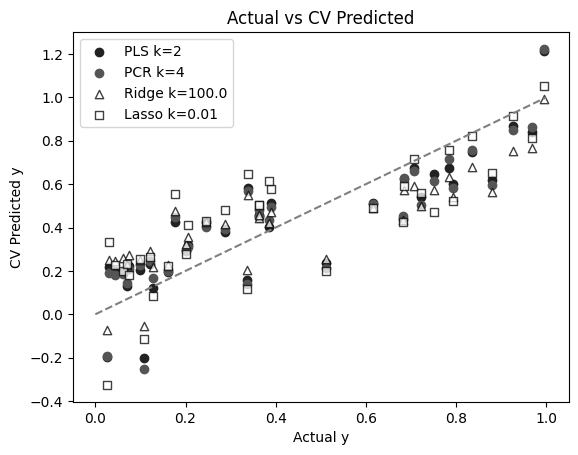

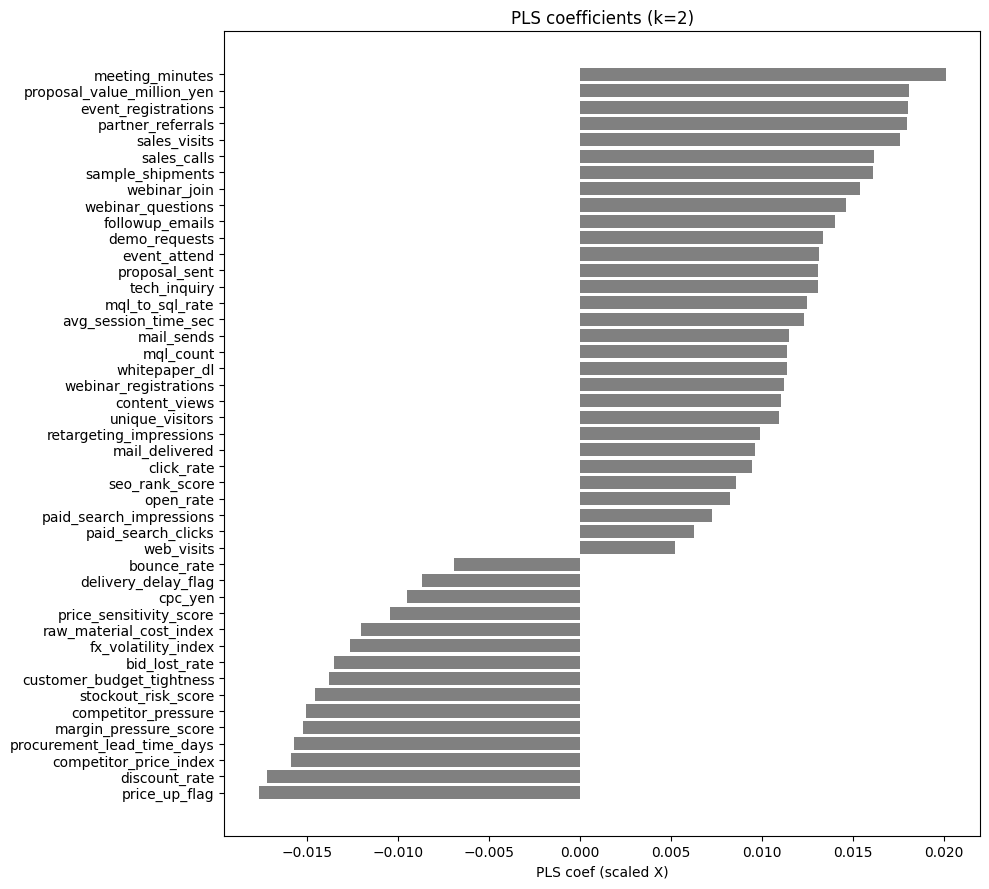

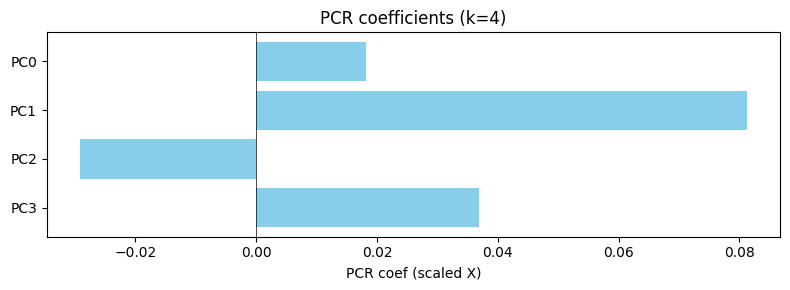

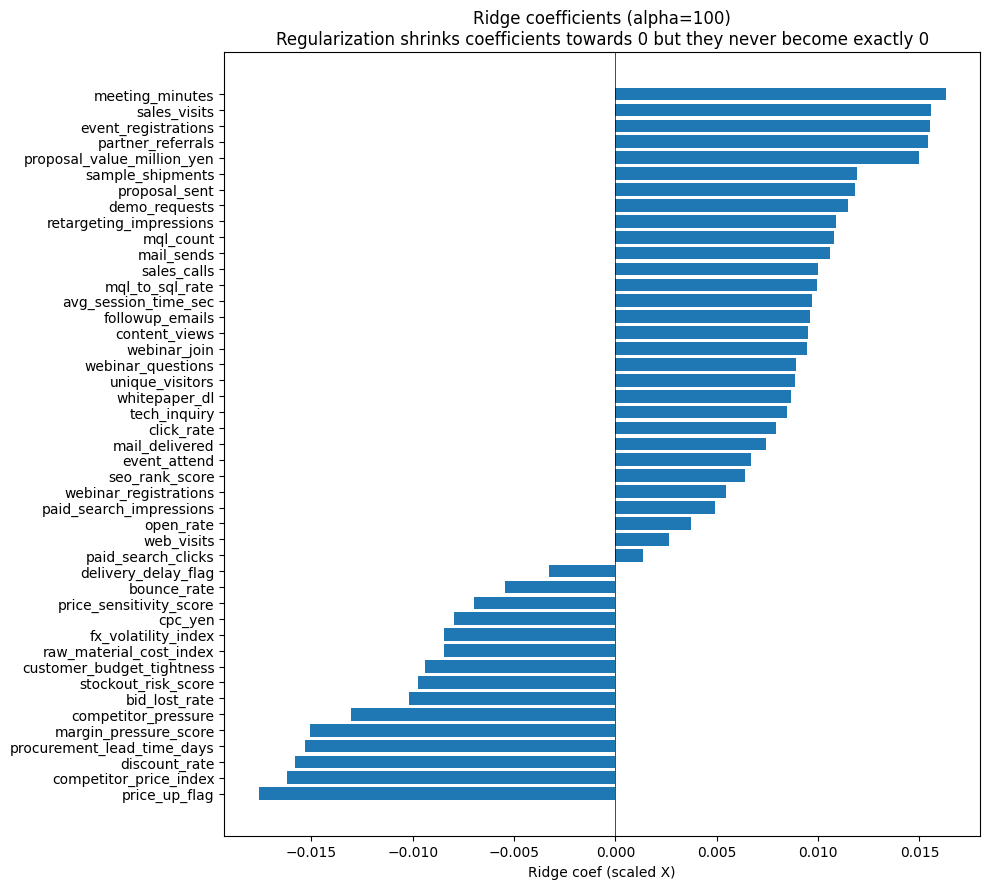

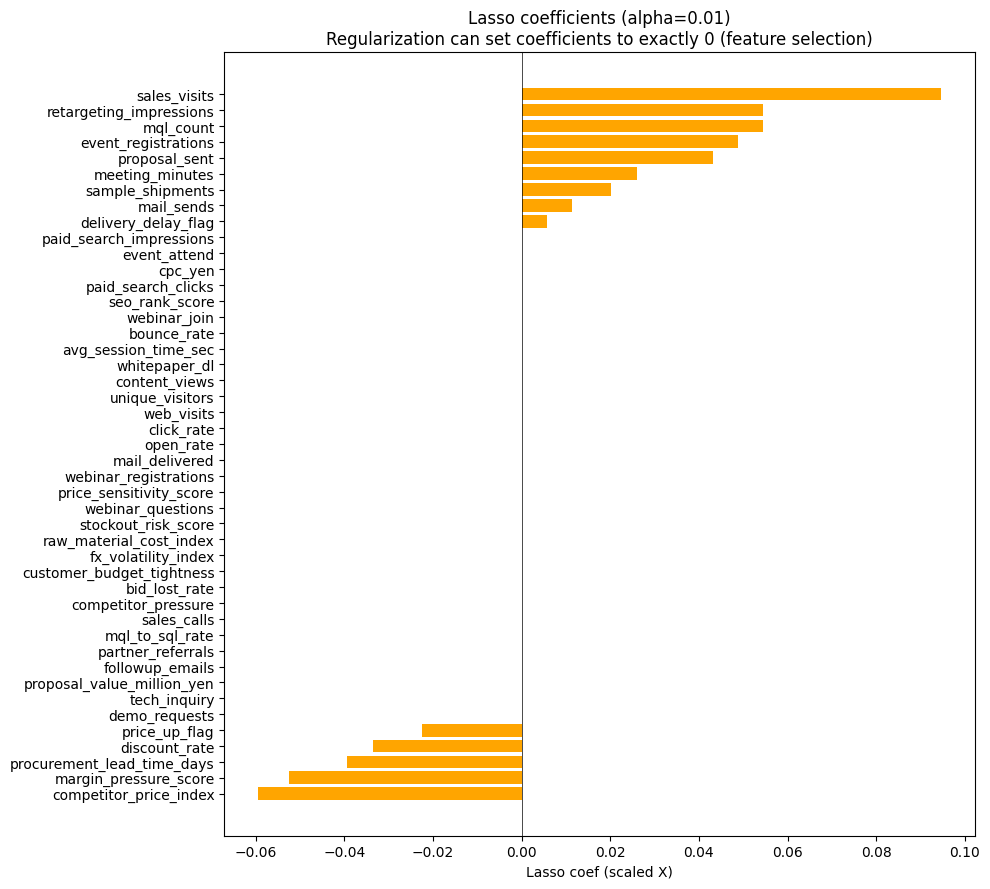

Lasso regression: 14/45 features are used (sparsity)


In [19]:
# 可視化：予測値と実測値
plt.figure()
plt.scatter(y, pls_pred[best_pls], label=f"PLS k={best_pls}", color="#222222")  # 濃いグレー (PLS:最も濃い)
plt.scatter(y, pcr_pred[best_pcr], label=f"PCR k={best_pcr}", color="#555555")  # 2番目に濃いグレー
plt.scatter(
    y, ridge_pred, 
    label=f"Ridge k={best_alpha}", 
    color="white", 
    edgecolor="#000000", 
    alpha=0.75, 
    marker='^',
    linewidths=1.0
)  # 明るいグレーの縁取り白抜き
plt.scatter(
    y, lasso_pred, 
    label=f"Lasso k={best_lasso_alpha}", 
    color="white", 
    edgecolor="#000000", 
    alpha=0.75, 
    marker='s',
    linewidths=1.0
)  # 最も明るいグレーの縁取り白抜き
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Actual y")
plt.ylabel("CV Predicted y")
plt.title("Actual vs CV Predicted")
plt.legend()
plt.show()

# 回帰係数(PLS)
plt.figure(figsize=(10, max(8, int(len(weights.index) * 0.2))))  # 行数に応じて高さ調整
plt.barh(pls_coef.index, pls_coef.values, color="gray")
plt.xlabel("PLS coef (scaled X)")
plt.title(f"PLS coefficients (k={best_pls})")
plt.tight_layout()
plt.show()

# 回帰係数(PCR)
# PCA + 線形回帰による回帰係数（インデックス降順で表示）
pcr_coef_sorted = pcr_coef.sort_index(ascending=False)
plt.figure(figsize=(8,3))
plt.barh(pcr_coef_sorted.index, pcr_coef_sorted.values, color="skyblue")
plt.xlabel("PCR coef (scaled X)")
plt.title(f"PCR coefficients (k={best_pcr})")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# 回帰係数(Ridge)
# 正則化により係数が0に近づくが、完全には0にならない（shrinkage）
plt.figure(figsize=(10, max(8, int(len(weights.index) * 0.2))))  # 行数に応じて高さ調整
plt.barh(ridge_coef.index, ridge_coef.values)
plt.xlabel("Ridge coef (scaled X)")
plt.title(f"Ridge coefficients (alpha={best_alpha:g})\nRegularization shrinks coefficients towards 0 but they never become exactly 0")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# 回帰係数(Lasso)
# 正則化により係数が0になる変数がある（スパース性：変数選択）
plt.figure(figsize=(10, max(8, int(len(weights.index) * 0.2))))  # 行数に応じて高さ調整
plt.barh(lasso_coef.index, lasso_coef.values, color="orange")
plt.xlabel("Lasso coef (scaled X)")
plt.title(f"Lasso coefficients (alpha={best_lasso_alpha:g})\nRegularization can set coefficients to exactly 0 (feature selection)")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Lasso回帰のスパース性を確認（係数が0でない変数の数）
n_nonzero_lasso = (lasso_coef != 0).sum()
n_total = len(lasso_coef)
print(f"Lasso regression: {n_nonzero_lasso}/{n_total} features are used (sparsity)")